In [1]:
import numpy as np
import treeQuadrature as tq

In [2]:
class SimpleGaussian:
    '''
    Likelihood: N(0, 1/(10*sqrt(2)))
    Prior: U(-1, 1)
    '''
    def __init__(self, D):
        self.D = D
        self.d = tq.exampleDistributions.MultivariateNormal(D=D, mean=[0.0]*D, cov=1/200)
        self.low = -1.0
        self.high = 1.0
        self.p = tq.exampleDistributions.Uniform(D=D, low=self.low, high=self.high)
        
        # Calculate truth
        self.answer = 1/(2.0**D)
        
    def pdf(self, X):
        # Combined pdf ie d(x)*p(x)
        return self.d.pdf(X) * self.p.pdf(X)

$$ \int_{-1}^{1}d(x)p(x) dx $$

$$ 1/(2^D) \cdot \int_{-1}^{1}d(x) dx $$

In [12]:
from queue import SimpleQueue

# Define the Integrator we gonna be testing today
class SimpleIntegrator:
    '''
    A simple integrator has the following pattern:
        - Draw <N> samples
        - Keep performing <split> method on containers...
        - ...until each container has less than <P> samples
        - Then perform  <integral> on each container and sum.
    '''
    
    def __init__(self, N, P):
        self.N = N
        self.P = P
        
    def __call__(self, problem):        
        # Draw samples
        X = problem.d.rvs(self.N)
        self._X = X
        y = problem.pdf(X)
        
        # Construct root container
        D = problem.D
        root = tq.Container(X, y, mins=[problem.low]*D, maxs=[problem.high]*D)
        
        # Contstruct tree using a FIFO queue
        finished_containers = []
        q = SimpleQueue()
        q.put(root)

        while not q.empty():

            c = q.get()

            if c.N <= self.P:
                finished_containers.append(c)
            else:
                children = tq.splits.kdSplit(c)
                for child in children:
                    q.put(child)

        # Integrate containers
        contributions = [tq.containerIntegration.randomIntegral(cont, problem.pdf, n=40) for cont in finished_containers]
        G = np.sum(contributions)
        
        return G, finished_containers, contributions

In [122]:
N = 100_000
P = 10

problem = SimpleGaussian(10)
integ = SimpleIntegrator(N, P)
G, fcs, cs1 = integ(problem)

In [124]:
import matplotlib.pyplot as plt
from matplotlib import cm

# fig = plt.figure(figsize=(8,8))
# ax = fig.add_subplot()
# ax.set_xlim([-0.3,0.3])
# ax.set_ylim([-0.3,0.3])
# cmap = cm.get_cmap('YlOrRd', 256)

cs = tq.utils.scale(cs1)

print(f'pcntError: {100 * (G - problem.answer) / problem.answer}')

# for container, contribution in zip(fcs, cs):
#     tq.visualisation.plotContainer(ax, container, plot_samples=False, fill=True, ec='black', facecolor=cmap(contribution), alpha=0.4)

pcntError: -97.09914430986926


In [186]:
def remove_small(nremove, cs, fcs):
    a, b = zip(*sorted(zip(cs, fcs)))
    I = np.zeros(nremove+1)
    I[0] = np.sum(a)
    arunning = np.sum(a)
    total = 100_000
    nrunning = 100_000
    for i in range(nremove):
        atemp = a[i]
        arunning -= atemp
        nrunning -= b[i].N
        I[i + 1] = total / nrunning * arunning
    return I

In [174]:
problem.answer

0.0009765625

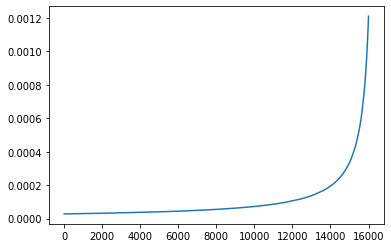

In [187]:
plt.plot(remove_small(16000, cs1, fcs))
plt.show()

In [157]:
G

2.8328668848933097e-05